In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: >

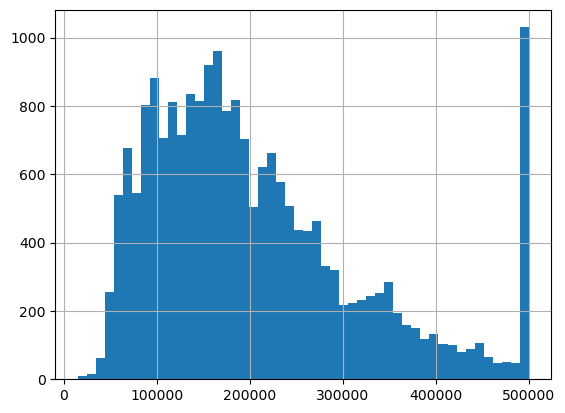

In [19]:
data.median_house_value.hist(bins=50)

In [21]:
df = data[(data.ocean_proximity =='<1H OCEAN') | (data.ocean_proximity =='INLAND')]
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
                 'median_income', 'median_house_value']]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            15687 non-null  float64
 1   longitude           15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


### Question 2

In [23]:
df.population.median()

1195.0

### Question 3

In [24]:
np.random.seed(42)
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [29]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [30]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [34]:
def prepare_X(df, fill_nan_zero=True):
    if fill_nan_zero==True:
        df = df.fillna(0)
    else:
        df = df.fillna(df.total_bedrooms.mean())
    X = df.values
    return X

In [35]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [39]:
X_train_nan = prepare_X(df_train)
w_0, w = train_linear_regression(X_train_nan, y_train)
y_pred_nan = w_0 + X_train_nan.dot(w)

In [40]:
X_train_notnan = prepare_X(df_train, fill_nan_zero=False)
w_0, w = train_linear_regression(X_train_notnan, y_train)
y_pred_notnan = w_0 + X_train_notnan.dot(w)

In [44]:
rmse_nan = rmse(y_train, y_pred_nan)
rmse_notnan = rmse(y_train, y_pred_notnan)
print(round(rmse_nan, 2), round(rmse_notnan, 2))

0.34 0.34


### Question 4

In [45]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [48]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 2))

     0 0.34
 1e-06 0.34
0.0001 0.34
 0.001 0.34
  0.01 0.34
   0.1 0.34
     1 0.34
     5 0.35
    10 0.35


### Question 5

In [51]:
rmse_scores = np.array([])
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)

    w_0, w = train_linear_regression_reg(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    rmse_scores = np.append(rmse_scores, rmse(y_val, y_pred))
    
    
    
print(round(rmse_scores.std(), 3))

0.005


### Question 6

In [58]:
np.random.seed(9)
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

X_train = prepare_X(pd.concat([df_train, df_val]))
X_test = prepare_X(df_test)
y_train =np.concatenate([y_train, y_val])

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
y_pred = w_0 + X_test.dot(w)
print(rmse(y_test, y_pred))

0.3350104893065672
